In [3]:
!pip install matplotlib-venn

In [5]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [7]:
!pip install matminer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 42.6 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=4354

In [8]:
import matminer
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import pandas as pd
import numpy as np
from matminer.datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [9]:
# 1. Load the 'matbench_perovskites' dataset
dataset = load_dataset('matbench_perovskites')
dataset = dataset.dropna()

# 2. Prepare data (features and target)
structures = dataset['structure']  # Perovskite structures in pymatgen Structure format
y = dataset['e_form']  # Target variable: formation energy

Fetching matbench_perovskites.json.gz from https://ml.materialsproject.org/projects/matbench_perovskites.json.gz to /usr/local/lib/python3.11/dist-packages/matminer/datasets/matbench_perovskites.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_perovskites.json.gz in MB: 4.194304MB [00:00, 174.25MB/s]                


In [10]:
# Initialize the XRDCalculator object
xrd_calculator = XRDCalculator()

# Function to extract XRD features: peak intensities
def extract_xrd_features(structure):
    pattern = xrd_calculator.get_pattern(structure)  # Compute XRD pattern
    return pattern.y  # Return the intensities (y-values) of the diffraction peaks

# Featurize each structure
X = [extract_xrd_features(structure) for structure in structures]

# Save the features DataFrame X to a pickle file
with open('features_X.pkl', 'wb') as f:
    pickle.dump(X, f)

# Load the features DataFrame X from the pickle file
with open('features_X.pkl', 'rb') as f:
    X_loaded = pickle.load(f)

In [11]:

# Convert the list of features into a DataFrame
X = pd.DataFrame(X_loaded)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# 3. Implement Cross-Validation
# Define the scoring metrics
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),  # Root Mean Squared Error
    'R2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(
    rf_model,       # Random Forest Regressor
    X,              # Feature matrix
    y,              # Target variable
    cv=5,           # Number of folds
    scoring=scoring, # Scoring metrics
    return_train_score=True,
    n_jobs=-1       # Use all available cores
    )

In [14]:
# Display cross-validation results
print("Cross-Validation Results:")
for metric in scoring.keys():
    print(f"Mean {metric} (Train): {np.mean(cv_results[f'train_{metric}']):.4f}")
    print(f"Mean {metric} (Test): {np.mean(cv_results[f'test_{metric}']):.4f}")
    print(f"Std {metric} (Test): {np.std(cv_results[f'test_{metric}']):.4f}")
    print()

Cross-Validation Results:
Mean MAE (Train): 0.1272
Mean MAE (Test): 0.3375
Std MAE (Test): 0.0056

Mean RMSE (Train): nan
Mean RMSE (Test): nan
Std RMSE (Test): nan

Mean R2 (Train): 0.9435
Mean R2 (Test): 0.6085
Std R2 (Test): 0.0150



In [17]:

# Make predictions on the test set
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)


# Fixed RMSE calculation
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [18]:
# Evaluation Metrics
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"Train RMSE: {calculate_rmse(y_train, y_pred_train):.4f}")
print(f"Test RMSE: {calculate_rmse(y_test, y_pred_test):.4f}")
print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")

Train MAE: 0.1266
Test MAE: 0.3394
Train RMSE: 0.1751
Test RMSE: 0.4643
Train R²: 0.9442
Test R²: 0.6158


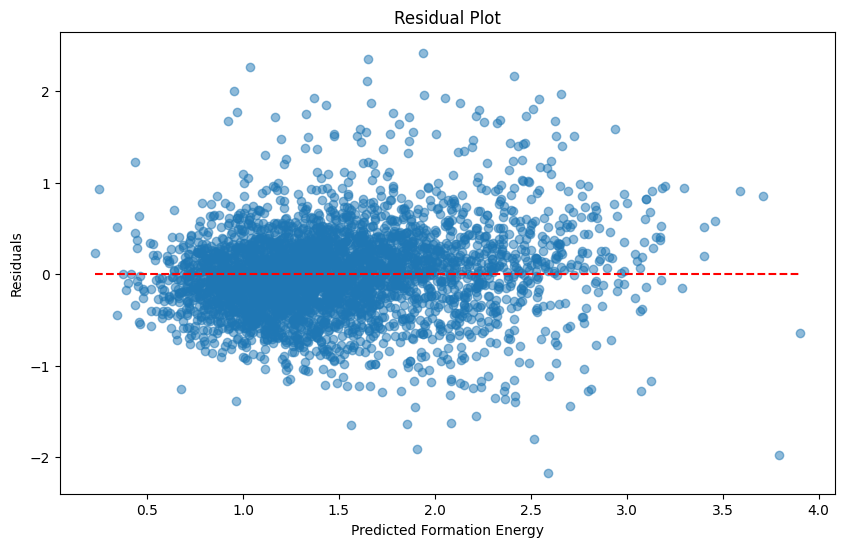

In [19]:
# Residual Plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test), colors='red', linestyles='--')
plt.xlabel('Predicted Formation Energy')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

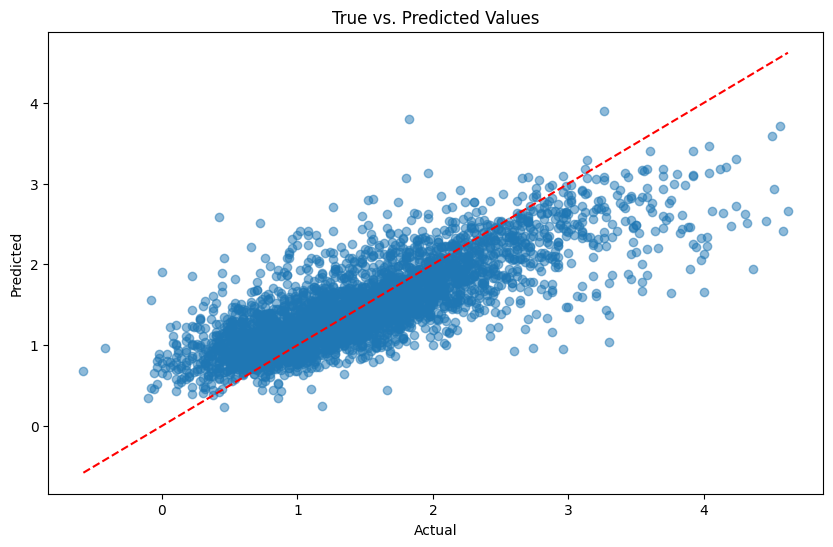

In [20]:
# Parity Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('True vs. Predicted Values')
plt.show()

In [21]:

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std of training and validation scores
train_scores_mean = np.mean(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)

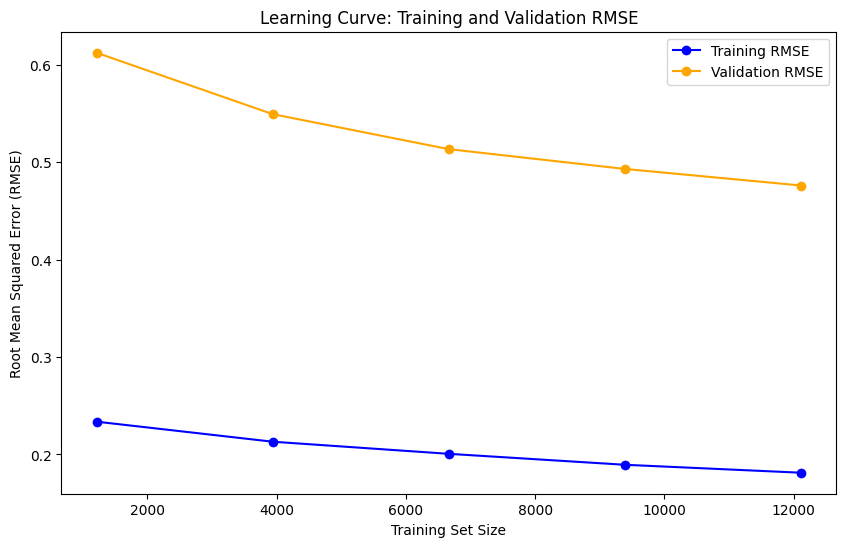

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.sqrt(train_scores_mean), 'o-', color="blue", label="Training RMSE")
plt.plot(train_sizes, np.sqrt(test_scores_mean), 'o-', color="orange", label="Validation RMSE")
plt.xlabel('Training Set Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Learning Curve: Training and Validation RMSE')
plt.legend()
plt.show()

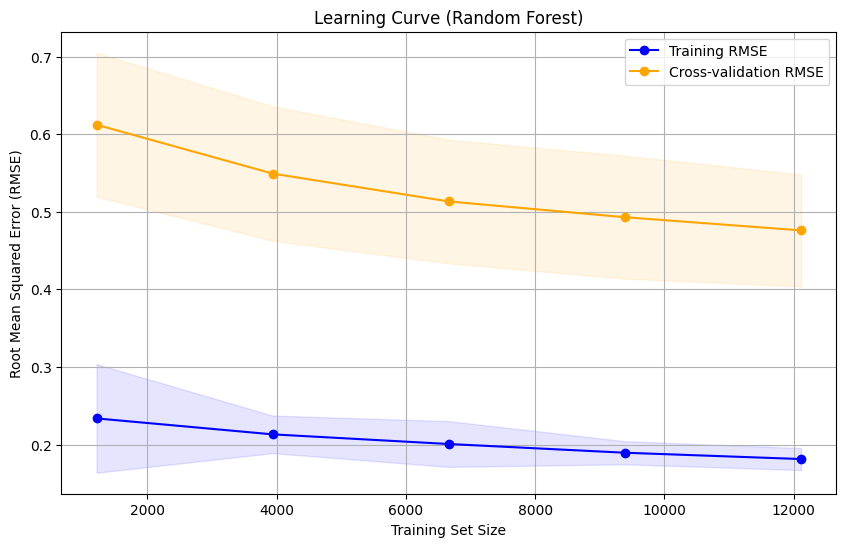

In [23]:
# Calculate mean and std of training and validation scores
train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.sqrt(train_scores_mean), 'o-', color="blue", label="Training RMSE")
plt.plot(train_sizes, np.sqrt(test_scores_mean), 'o-', color="orange", label="Cross-validation RMSE")

# Fill between for standard deviation
plt.fill_between(train_sizes,
                 np.sqrt(train_scores_mean) - np.sqrt(train_scores_std),
                 np.sqrt(train_scores_mean) + np.sqrt(train_scores_std),
                 alpha=0.1, color="blue")
plt.fill_between(train_sizes,
                 np.sqrt(test_scores_mean) - np.sqrt(test_scores_std),
                 np.sqrt(test_scores_mean) + np.sqrt(test_scores_std),
                 alpha=0.1, color="orange")

plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Learning Curve (Random Forest)")
plt.legend(loc="best")
plt.grid()

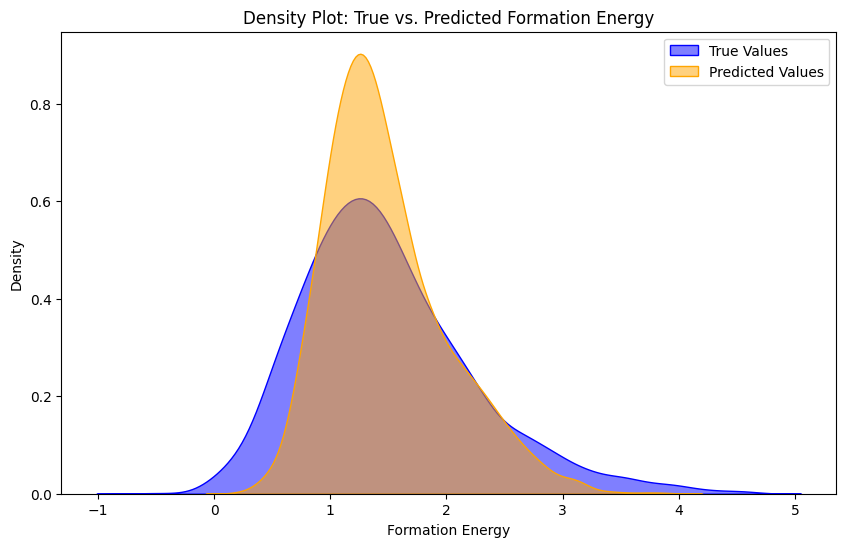

In [24]:
# Density Plot: True vs. Predicted Formation Energy
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='True Values', color='blue', fill=True, alpha=0.5)
sns.kdeplot(y_pred_test, label='Predicted Values', color='orange', fill=True, alpha=0.5)
plt.xlabel('Formation Energy')
plt.ylabel('Density')
plt.title('Density Plot: True vs. Predicted Formation Energy')
plt.legend()
plt.show()

In [25]:
# Save the trained model using pickle
with open('random_forest_xrd_manual_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)